In [6]:
import os
from PIL import Image
import pandas as pd
from sklearn.model_selection import train_test_split
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC

## Read in the age, gender, ethnicity data

In [7]:
import pandas as pd
import numpy as np

age_gender_ethnicity_df = pd.read_csv('age_gender.csv')


pixels = []
gender = []
ethnicity = []
raw_images = []

for row in age_gender_ethnicity_df.iterrows():
    one_d = np.fromstring(row[1]['pixels'], sep = ' ', dtype = np.uint8)
    pixels.append(one_d)
    raw_images.append(one_d.reshape(48,48))
    gender.append(row[1]['gender'])
    ethnicity.append(row[1]['ethnicity'])


# print(pixels[0:10])
first_df = pd.DataFrame(pixels)
first_df['gender'] = gender
first_df['ethnicity'] = ethnicity

first_df.head()

,0,1,2,3,4,5,6,7,8,9,...,2296,2297,2298,2299,2300,2301,2302,2303,gender,ethnicity
0,-127,-128,-128,126,127,-126,-123,-121,-117,-114,...,-122,-118,-114,-112,-112,-110,-110,-110,0,2
1,-92,74,111,-88,-87,-85,-81,-74,-72,-68,...,-33,-15,-20,-24,-52,-74,-86,-108,0,2
2,67,70,71,70,69,67,70,79,90,103,...,116,116,117,117,115,112,111,108,0,2
3,-63,-59,-58,-56,-57,-56,-54,-53,-52,-51,...,-29,-28,-28,-26,-25,-21,-17,-10,0,2
4,-54,-51,-47,-46,-47,-47,-46,-45,-44,-42,...,-89,-89,-88,-85,-85,-89,-93,-95,0,2


## Plotting random sample of faces with ethnicity and gender values

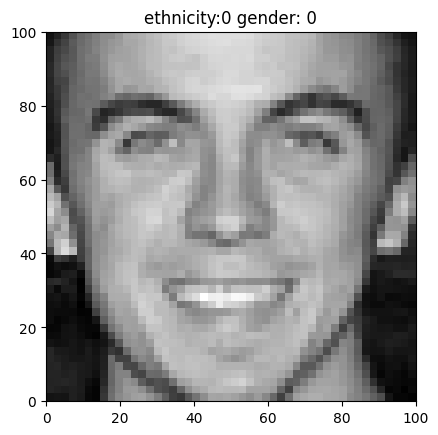

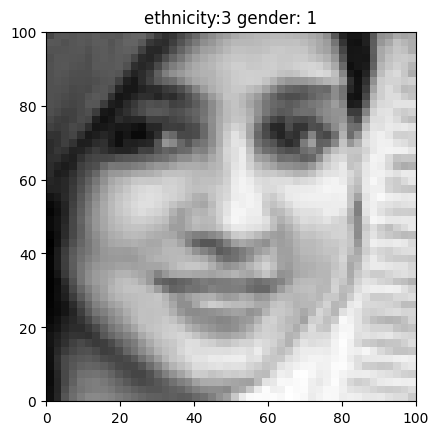

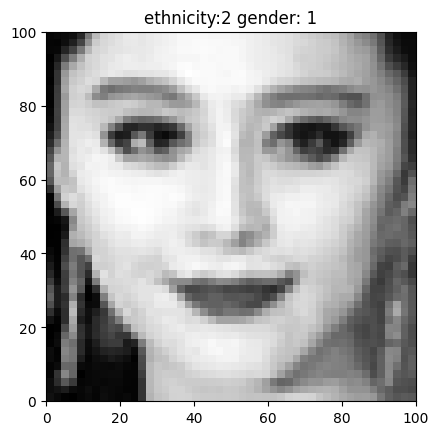

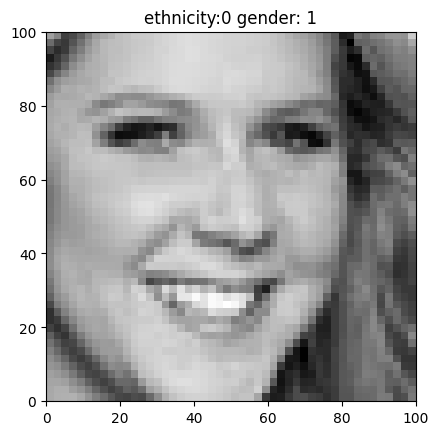

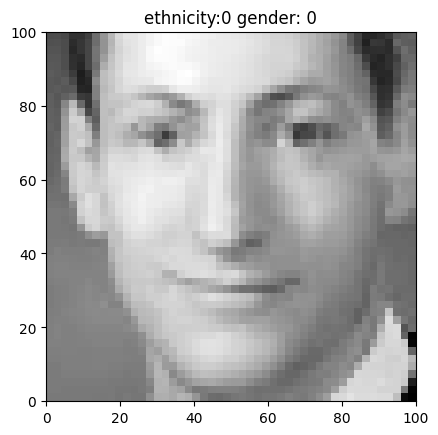

In [8]:
import numpy as np
from matplotlib import pyplot as plt
import random 

for i in range(0,5):
    rand = random.randint(0, len(pixels))
    im = raw_images[rand]
    label = "ethnicity:" + str(ethnicity[rand])
    label += " gender: " + str(gender[rand]) 
    fig, ax = plt.subplots()
    im = ax.imshow(im, extent=[0, 100, 0, 100], cmap='gray')
    plt.title(str(label))
    plt.show()

## Generic neural network class

In [9]:
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split

device = torch.device('cpu')
print('device: ', device)

class NN(nn.Module):
    def __init__(self, n_layers, hidden_size, activations):
        super().__init__()
            
        assert len(hidden_size) > 0
        act = {'sigmoid': nn.Sigmoid(), 'tanh': nn.Tanh(), 'relu': nn.ReLU(), 'identity': nn.Identity()}
        
        self.layers = []
        for i in range(n_layers - 1):
            self.layers.append(nn.Linear(hidden_size[i], hidden_size[i + 1]))
            if activations[i] in act:
                self.layers.append(act[activations[i]])
            else:
                assert activations in ['sigmoid', 'tanh', 'relu', 'identity']

        self.layers = nn.ModuleList(self.layers)

    def forward(self, x):
        for idx in range(len(self.layers) - 1):
            x = self.layers[idx](x)

        return x

def train_nn(model, optimizer, criterion, n_epoch, data, label):

    # print(type(data))
    data = torch.tensor(data, dtype=torch.float).to(device)
    label = label.tolist()
    label = torch.tensor(label, dtype=torch.long).squeeze().to(device)

    for epoch in range(n_epoch):
        predict = model(data)
        predict = predict.reshape(-1) #
        #print(predict.shape)
        optimizer.zero_grad()

       
        loss = criterion(predict, label)
        loss.backward()
        optimizer.step()

    return model.named_parameters

def model_accuracy(model, data, label):
    data = torch.tensor(data, dtype=torch.float).to(device)
    
    predict = model(data)
    
    predict = np.rint(predict.detach().numpy())

    correct = 0
    count = 0

    label = label.values
    for index, p in enumerate(predict):
        if abs(abs(p[0]) - label[index]) < 10:
            correct += 1;
        count += 1

    return correct/count


device:  cpu


# Train neural network where the features are the pixels and target is the gender

In [10]:
n_epoch = 1000
learning_rate = 0.1
settings = {
'hidden layer = 2, neuron = 30, 30, act=tanh': {'hs': [2304, 30, 30, 1], 'act':['identity', 'tanh', 'tanh', 'sigmoid']}
}

target = first_df['gender']
features = np.array(pixels)


X_train, X_test, y_train, y_test = train_test_split(features, target, random_state=3000)

model = None 

for setting in settings:
    print('---------------- Setting -------------------')
    print(setting)

    n_layers = len(settings[setting]['hs'])
    hidden_size = settings[setting]['hs']
    activations = settings[setting]['act']

    model = NN(n_layers, hidden_size, activations).to(device)
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    
    criterion = nn.L1Loss() 

    param = train_nn(model, optimizer, criterion, n_epoch, X_train, y_train)

    print('Train Accuracy: ', model_accuracy(model, X_train, y_train))
    print('Test Accuracy: ', model_accuracy(model, X_test, y_test))

gender_model = model



---------------- Setting -------------------
hidden layer = 2, neuron = 30, 30, act=tanh
Train Accuracy:  1.0
Test Accuracy:  1.0


In [11]:

# gender_map = {'2.0': 'f', '1.0': 'male'}

# i = []
# file_paths = ["./max.png", "./bill.jpg", './jack.jpg', "./holtzen.png", "./obama.jpg", './foster.jpg', './michelle.jpg', './emma.jpg']
# raw_images = []
# raw_images_predictions = []
# for file_name in file_paths:
#     image = Image.open(file_name).convert('L').resize((48, 48))
#     raw_images.append(image)
    
#     i.append(np.array(image).flatten())
    
#     i = np.array(i)

#     data = torch.tensor(i[0], dtype=torch.float).to(device)

#     predic = abs(np.rint(model(data)[0].detach().numpy()))
#     raw_images_predictions.append(predic)

#     i = []


# for i in range(len(raw_images)):
#     im = raw_images[i]
#     label = raw_images_predictions[i]
#     fig, ax = plt.subplots()
#     im = ax.imshow(im, extent=[0, 100, 0, 100], cmap='gray')
#     plt.title("prediction: gender: " + str(label))
#     plt.show()


In [16]:
n_epoch = 1000
learning_rate = 0.1
settings = {
'hidden layer = 1, neuron = 30, 30, act=tanh' : {'hs': [2304, 30, 30, 1], 'act': ['identity','tanh', 'sigmoid']},
# 'hidden layer = 3, neuron = 50, 50, 50, act=tanh': {'hs': [2500, 50, 50, 50, 1], 'act':['identity', 'tanh', 'tanh', 'tanh', 'sigmoid']},
# 'hidden layer = 1, neuron = 50, act=relu': {'hs': [2500, 50, 2], 'act': ['identity','relu', 'sigmoid']},
# 'hidden layer = 2, neuron = 30, 30, act=relu': {'hs': [2500, 30, 30, 1], 'act':['identity', 'relu', 'relu', 'sigmoid']},
# 'hidden layer = 2, neuron = 40, 40, act=relu': {'hs': [2500, 40, 40, 1], 'act':['identity', 'relu', 'relu', 'sigmoid']},
# 'hidden layer = 2, neuron = 50, 50, act=relu': {'hs': [2500, 50, 50, 1], 'act':['identity', 'relu', 'relu', 'sigmoid']},
# 'hidden layer = 2, neuron = 100, 100, act=relu': {'hs': [2500, 100, 100, 1], 'act':['identity', 'relu', 'relu', 'sigmoid']},
# 'hidden layer = 3, neuron = 50, 50, 50, act=relu': {'hs': [2500, 50, 50, 50, 1], 'act':['identity', 'relu', 'relu', 'relu', 'sigmoid']}
}

target = None
features = None

target = first_df['ethnicity']
features = np.array(pixels)


X_train, X_test, y_train, y_test = train_test_split(features, target, random_state=3000)

model = None 
n_layers = None
hidden_size = None
activations = None
optimizer = None
criterion = None
param = None

for setting in settings:
    print('---------------- Setting -------------------')
    print(setting)

    n_layers = len(settings[setting]['hs'])
    hidden_size = settings[setting]['hs']
    activations = settings[setting]['act']

    model = NN(n_layers, hidden_size, activations).to(device)
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    
    criterion = nn.L1Loss() 

    param = train_nn(model, optimizer, criterion, n_epoch, X_train, y_train)

    print('Train Accuracy: ', model_accuracy(model, X_train, y_train))
    print('Test Accuracy: ', model_accuracy(model, X_test, y_test))

ethnicity_model = model



---------------- Setting -------------------
hidden layer = 1, neuron = 50, act=tanh
Train Accuracy:  1.0
Test Accuracy:  1.0


## Read In Data and Featurization

Parses every age folder in the ./face_age directory, using the PIL library to read in each image. Convert each image into a two demensional array of grayscale pixel value representations. It is then resizes to be a 50 pixel by 50 pixel array, so constrain the number of features. Then we convert to a numpy array and flatten. We then rotate each image by a random degree value between -22 and 22, to add more data to the set and account for different head positions.  

In [17]:
X = []
Y = []
raw_images = []
new_feature_images = []
width = 100
height = 100
INPUT_CLASSES_DIR = 'face_age/'

import numpy as np
import random

for folder_name,_,filenames in os.walk(INPUT_CLASSES_DIR):
    count = 0
    if folder_name !="face_age/":
        if int(folder_name[-3:]) < 70:
            for file in filenames:
                if count < 30:
                    file_path = folder_name +"/"+ file
                    image = Image.open(file_path).convert('L')

                    new_feature_images.append(np.array(image.resize((48,48))).flatten())

                    image = image.resize((width, height))
                    X.append(np.array(image).flatten())
                    raw_images.append(image)
                    Y.append(int(folder_name[-3:]))
                    count += 1

                    #add 2 random rotations of the image with a range of -15 to 15 degrees
                    for i in range(2):
                        degrees = random.randint(-22, 22);
                        rotated = image.rotate(degrees)
                        raw_images.append(rotated)
                        
                        new_feature_images.append(np.array(rotated.resize((48,48))).flatten())

                        X.append(np.array(rotated).flatten())
                        Y.append(int(folder_name[-3:]))


    else:
        pass




In [18]:
data = torch.tensor(new_feature_images, dtype=torch.float).to(device)
gender = gender_model(data)
gender = np.rint(gender.detach().numpy())

ethnicity = ethnicity_model(data)
ethnicity = np.rint(ethnicity.detach().numpy())



C:\Users\maxnb\AppData\Local\Temp\ipykernel_15416\2600875171.py:1: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ..\torch\csrc\utils\tensor_new.cpp:233.)
  data = torch.tensor(new_feature_images, dtype=torch.float).to(device)


In [19]:
import pandas as pd

df = pd.DataFrame(X)
df['gender'] = gender
df['ethnicity'] = ethnicity
df['age'] = Y

df.head()

,0,1,2,3,4,5,6,7,8,9,...,9993,9994,9995,9996,9997,9998,9999,gender,ethnicity,age
0,112,-125,-119,-119,-117,-117,-116,-114,-114,-111,...,-57,-54,-55,-57,-52,-45,-41,0.0,1.0,1
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0.0,1.0,1
2,0,0,0,0,0,0,0,0,0,90,...,0,0,0,0,0,0,0,0.0,1.0,1
3,-18,-21,-19,-18,-16,-21,-41,-58,-61,-57,...,123,-125,-115,-104,-96,-97,-95,0.0,1.0,1
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0.0,1.0,1


## Data Visualization
Randomly select some raw images to plot, with the title being the age

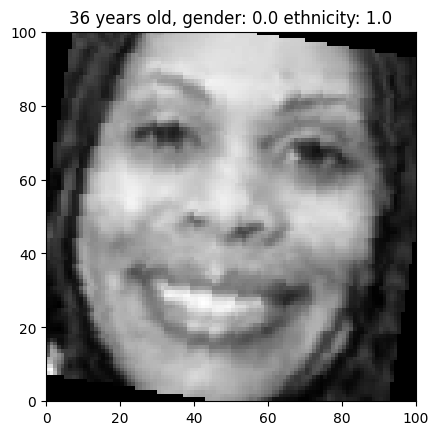

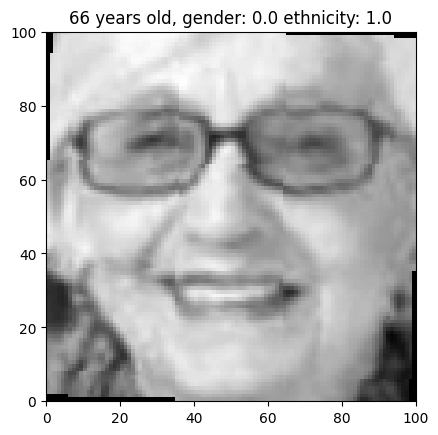

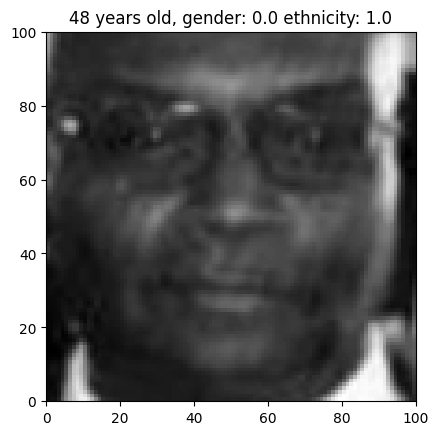

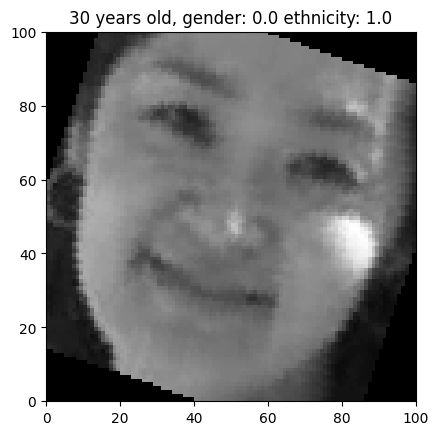

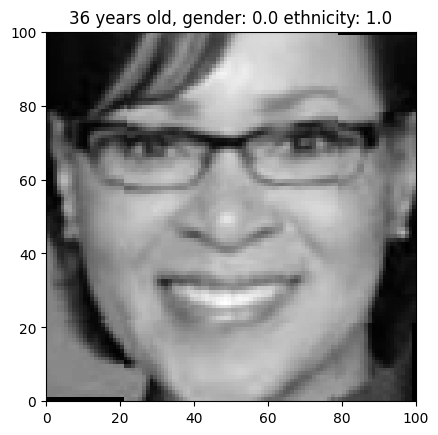

In [20]:
import numpy as np
from matplotlib import pyplot as plt

for i in range(0,5):
    rand = random.randint(0, len(X))
    im = raw_images[rand]
    label = Y[rand]
    fig, ax = plt.subplots()
    gender = df.iloc[rand]['gender']
    ethnicity = df.iloc[rand]['ethnicity']
    im = ax.imshow(im, extent=[0, 100, 0, 100], cmap='gray')
    # plt.title(str(label) + " years old, gender: " + gender_map[str(abs(gender))])
    plt.title(str(label) + " years old, gender: " + str(abs(gender)) + " ethnicity: " + str(ethnicity))
    plt.show()

#### Convert features and labels into a dataframe

Print shape of dataframe, showing (rows, columns), where the rows is the number of samples and the columns is number of features + targets.

In [21]:
print(df.shape)

(6198, 10003)


## SVM

Train a Support Vector Machine model with a random subset of the data as the training set. Trained 6 times, on three separate C values (regularization paramter) to see the effect on accuracy. 

In [22]:



def plot_effect_of_C(data):

    means = []
    Cs = []

    for d in data:
        means.append(d['our_test_acc'])
        Cs.append(d['C (regularization)'])


    plt.plot(range(len(Cs)),means)
    plt.xticks(range(len(Cs)), Cs)
    plt.title('hyperparameter vs accuracy (within 10 years on either side)')
    plt.xlabel('hyperparameter C')
    plt.ylabel('accuracy')
    plt.show()

def train_test_SVM(features, target):
    data_rows = []
    total_score = 0

    C =  [.8, .9, 1, 1.1, 1.2, 1.3, 2, 2.5]
    iters = len(C)
    for i in range(iters):
        X_train, X_test, y_train, y_test = train_test_split(features, target)

        model = SVC(max_iter=10000, C = C[i], kernel = 'rbf').fit(X_train, y_train)

        # Prediction accuracies and distributions in each age group
        actual = model.predict(X_test)
        expected = y_test.array
        correct = 0

        dictScores = {'0-5': 0, '6-10': 0, '11-15': 0, '16-25': 0, '+25': 0}
        for index, age in enumerate(actual):
            # How well the model perfroms with a 10 year gap
            if abs(age - expected[index]) < 10:
                correct += 1

            diff = abs(age - expected[index])

            if diff <= 5:
                dictScores['0-5']+=1
            elif diff <= 10:
                dictScores['6-10']+=1
            elif diff <= 15:
                dictScores['11-15']+=1
            elif diff <= 25:
                dictScores['16-25']+=1
            else:
                dictScores['+25']+=1


        train_acc = model.score(X_train, y_train)
        test_acc = model.score(X_test, y_test)

        total_score += test_acc

        data_rows.append({
            "C (regularization)": C[i],
            "train_acc": train_acc,
            "test_acc": test_acc,
            "our_test_acc": correct/len(X_test)
        })

        print(dictScores)

    plot_effect_of_C(data_rows)
    test_df = pd.DataFrame(data_rows)
    print('average score', total_score/iters, '\n',test_df)

   

## Create distinct features and target datasets
Run SVM

In [23]:
target = df['age']
df2 = df.drop(columns=['age'])
features = df2

In [24]:
# train_test_SVM(features, target)

## Logistic Regression

In [25]:
def train_test_logistic_regressor(features, target):

    data_rows = []
    total_score = 0
    iters = 1
    C =  [1]
    iters = len(C);
    for i in range(iters):
        X_train, X_test, y_train, y_test = train_test_split(features, target, train_size=.6)
        model = LogisticRegression(max_iter=10000, C = C[i]).fit(X_train, y_train)


        # Predict accuracies and distributions in each age group
        actual = model.predict(X_test)
        expected = y_test.array
        correct = 0

        dictScores = { '0-5': 0, '6-10': 0, '11-15': 0, '16-25': 0, '+25': 0}
        for index, age in enumerate(actual):
            # How well the model perfroms with a 10 year gap
            if abs(age - expected[index]) < 10:
                correct += 1

            diff = abs(age - expected[index])

            if diff <= 5:
                dictScores['0-5']+=1
            elif diff <= 10:
                dictScores['6-10']+=1
            elif diff <= 15:
                dictScores['11-15']+=1
            elif diff <= 25:
                dictScores['16-25']+=1
            else:
                dictScores['+25']+=1
                
        train_acc = model.score(X_train, y_train)
        test_acc = model.score(X_test, y_test)

        total_score += test_acc

        data_rows.append({
            "C (regularization)": C[i],
            "train_acc": train_acc,
            "test_acc": test_acc,
            "our_test_acc": correct/len(X_test)
        })

        print(dictScores)

    plot_effect_of_C(data_rows)
    test_df = pd.DataFrame(data_rows)
    print('average score', total_score/iters, '\n',test_df)

In [26]:
# train_test_logistic_regressor(features, target)

## Retrain the SVM model to test on custom pictures

In [27]:
# X_train, X_test, y_train, y_test = train_test_split(features, target)

# model = SVC(max_iter=10000).fit(X_train, y_train)

In [28]:
# i = []
# file_paths = ["./max.png", "./bill.jpg", './jack.jpg', "./holtzen.png"]
# raw_images = []
# raw_images_predictions = []
# for file_name in file_paths:
#     image = Image.open(file_name).convert('L').resize((100, 100))
#     raw_images.append(image)
    
#     i.append(np.array(image).flatten())

#     test_df = pd.DataFrame(i)

#     raw_images_predictions.append(model.predict([test_df.iloc[0]])[0])

#     i = []


# for i in range(len(raw_images)):
#     im = raw_images[i]
#     label = raw_images_predictions[i]
#     fig, ax = plt.subplots()
#     im = ax.imshow(im, extent=[0, 100, 0, 100], cmap='gray')
#     plt.title("prediction: " + str(label) + " years old")
#     plt.show()

    

In [29]:
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split

device = torch.device('cpu')
print('device: ', device)

class NN(nn.Module):
    def __init__(self, n_layers, hidden_size, activations):
        super().__init__()
            
        assert len(hidden_size) > 0
        act = {'sigmoid': nn.Sigmoid(), 'tanh': nn.Tanh(), 'relu': nn.ReLU(), 'identity': nn.Identity()}
        
        self.layers = []
        for i in range(n_layers - 1):
            self.layers.append(nn.Linear(hidden_size[i], hidden_size[i + 1]))
            if activations[i] in act:
                self.layers.append(act[activations[i]])
            else:
                assert activations in ['sigmoid', 'tanh', 'relu', 'identity']

        self.layers = nn.ModuleList(self.layers)

    def forward(self, x):
        for idx in range(len(self.layers) - 1):
            x = self.layers[idx](x)

        return x

def train_nn(model, optimizer, criterion, n_epoch, data, label):

    # print(type(data))
    data = torch.tensor(data, dtype=torch.float).to(device)
    label = label.tolist()
    label = torch.tensor(label, dtype=torch.long).squeeze().to(device)

    for epoch in range(n_epoch):
        predict = model(data)
        predict = predict.reshape(-1) #
        #print(predict.shape)
        optimizer.zero_grad()

       
        loss = criterion(predict, label)
        loss.backward()
        optimizer.step()

    return model.named_parameters

def model_accuracy(model, data, label):
    data = torch.tensor(data, dtype=torch.float).to(device)
    
    predict = model(data)
    
    predict = np.rint(predict.detach().numpy())

    correct = 0
    count = 0

    label = label.values
    for index, p in enumerate(predict):
        if abs(abs(p[0]) - label[index]) < 10:
            correct += 1;
        count += 1

    return correct/count


device:  cpu


In [30]:
n_epoch = 1000
learning_rate = 0.1
settings = {
'hidden layer = 1, neuron = 50, act=tanh' : {'hs': [10002, 50, 1], 'act': ['identity','tanh', 'sigmoid']},
'hidden layer = 2, neuron = 30, 30, act=tanh': {'hs': [10002, 30, 30, 1], 'act':['identity', 'tanh', 'tanh', 'sigmoid']},
'hidden layer = 2, neuron = 40, 40, act=tanh': {'hs': [10002, 40, 40, 1], 'act':['identity', 'tanh', 'tanh', 'sigmoid']},
'hidden layer = 2, neuron = 50, 50, act=tanh': {'hs': [10002, 50, 50, 1], 'act':['identity', 'tanh', 'tanh', 'sigmoid']},
'hidden layer = 2, neuron = 100, 100, act=tanh': {'hs': [10002, 100, 100, 1], 'act':['identity', 'tanh', 'tanh', 'sigmoid']},
'hidden layer = 3, neuron = 50, 50, 50, act=tanh': {'hs': [10002, 50, 50, 50, 1], 'act':['identity', 'tanh', 'tanh', 'tanh', 'sigmoid']},
# 'hidden layer = 1, neuron = 50, act=relu': {'hs': [2500, 50, 2], 'act': ['identity','relu', 'sigmoid']},
# 'hidden layer = 2, neuron = 30, 30, act=relu': {'hs': [2500, 30, 30, 1], 'act':['identity', 'relu', 'relu', 'sigmoid']},
# 'hidden layer = 2, neuron = 40, 40, act=relu': {'hs': [2500, 40, 40, 1], 'act':['identity', 'relu', 'relu', 'sigmoid']},
# 'hidden layer = 2, neuron = 50, 50, act=relu': {'hs': [2500, 50, 50, 1], 'act':['identity', 'relu', 'relu', 'sigmoid']},
# 'hidden layer = 2, neuron = 100, 100, act=relu': {'hs': [2500, 100, 100, 1], 'act':['identity', 'relu', 'relu', 'sigmoid']},
# 'hidden layer = 3, neuron = 50, 50, 50, act=relu': {'hs': [2500, 50, 50, 50, 1], 'act':['identity', 'relu', 'relu', 'relu', 'sigmoid']}
}

X_train, X_test, y_train, y_test = train_test_split(features, target, random_state=3000)

train =  X_train.to_numpy()
test = X_test.to_numpy()

model = None 

for setting in settings:
    print('---------------- Setting -------------------')
    print(setting)

    n_layers = len(settings[setting]['hs'])
    hidden_size = settings[setting]['hs']
    activations = settings[setting]['act']

    model = NN(n_layers, hidden_size, activations).to(device)
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    
    #*regression loss L2 or L1, penalizes difference, rather than checking equality*
    criterion = nn.L1Loss() 

    param = train_nn(model, optimizer, criterion, n_epoch, train, y_train)

    print('Train Accuracy: ', model_accuracy(model, train, y_train))
    print('Test Accuracy: ', model_accuracy(model, test, y_test))



---------------- Setting -------------------
hidden layer = 1, neuron = 50, act=tanh
Train Accuracy:  0.7510757314974182
Test Accuracy:  0.3470967741935484
---------------- Setting -------------------
hidden layer = 2, neuron = 30, 30, act=tanh
Train Accuracy:  0.29388984509466437
Test Accuracy:  0.28903225806451616
---------------- Setting -------------------
hidden layer = 2, neuron = 40, 40, act=tanh
Train Accuracy:  0.2936746987951807
Test Accuracy:  0.2729032258064516
---------------- Setting -------------------
hidden layer = 2, neuron = 50, 50, act=tanh
Train Accuracy:  0.2923838209982788
Test Accuracy:  0.27483870967741936
---------------- Setting -------------------
hidden layer = 2, neuron = 100, 100, act=tanh
Train Accuracy:  0.32293459552495696
Test Accuracy:  0.30774193548387097
---------------- Setting -------------------
hidden layer = 3, neuron = 50, 50, 50, act=tanh
Train Accuracy:  0.4085628227194492
Test Accuracy:  0.32387096774193547


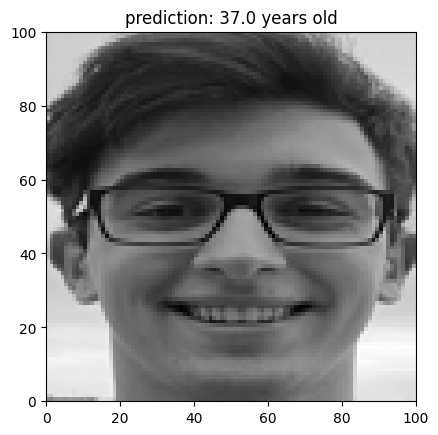

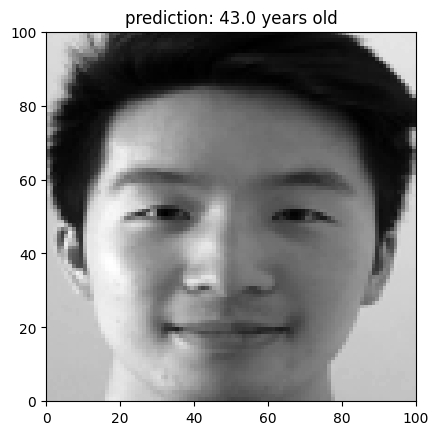

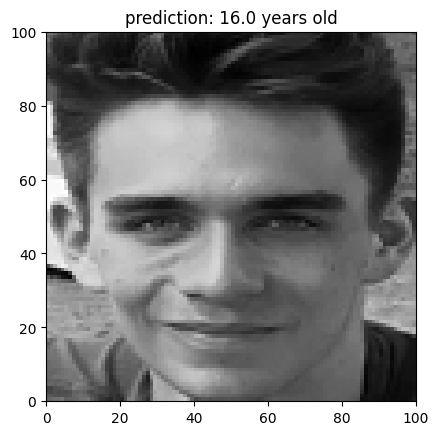

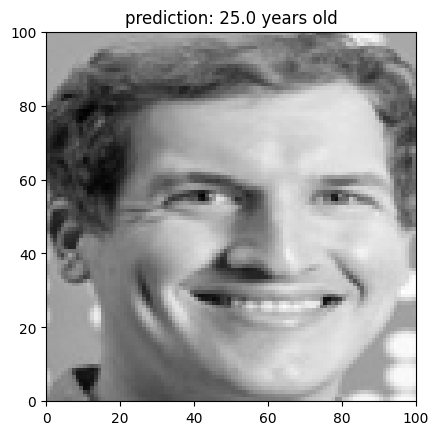

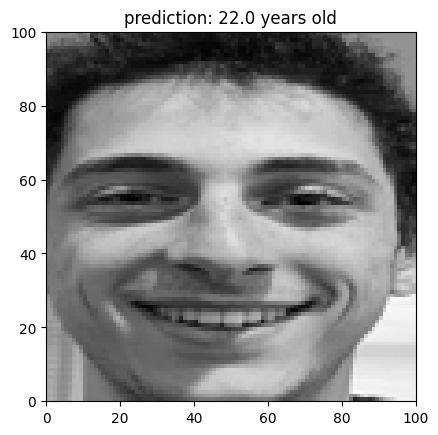

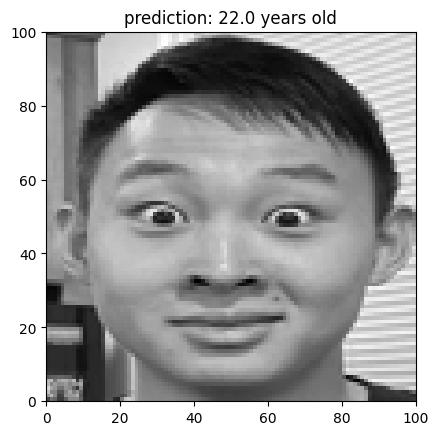

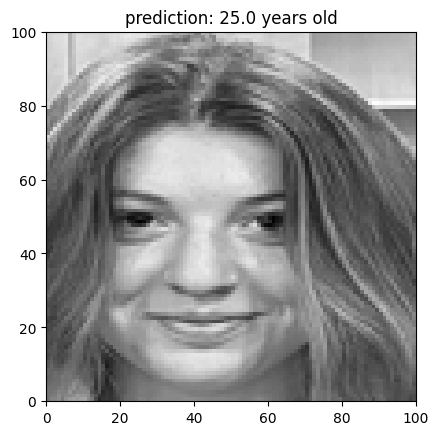

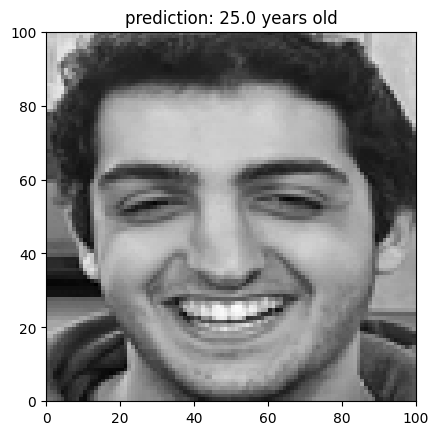

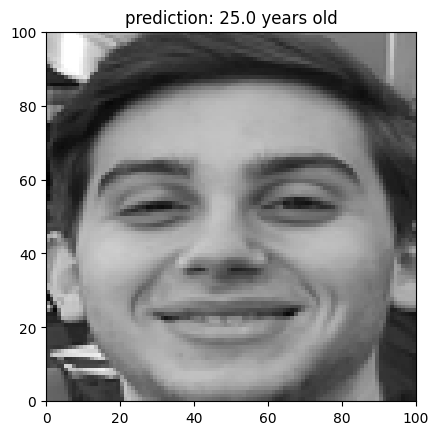

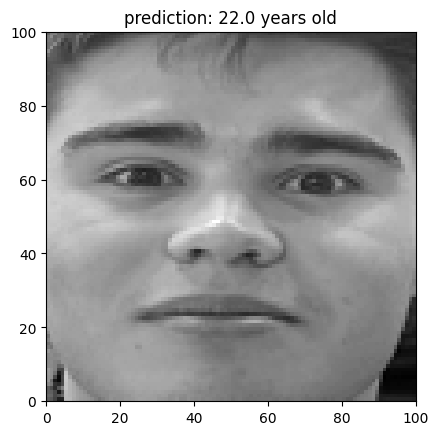

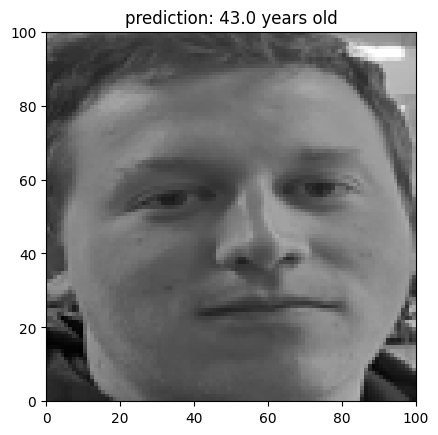

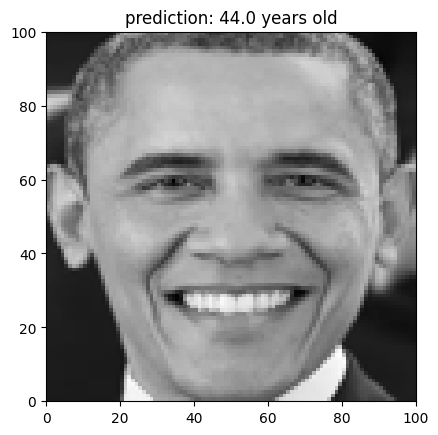

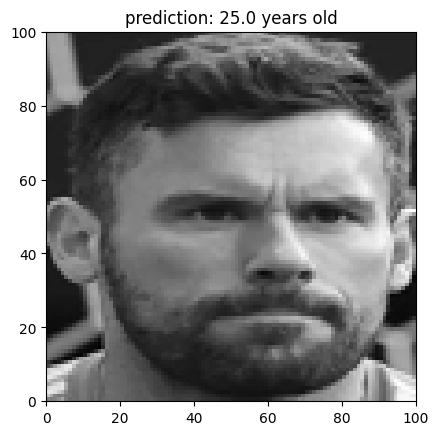

In [31]:
i = []
file_paths = ["./max.png", "./bill.jpg", './jack.jpg', "./holtzen.png", "./obama.jpg", './foster.jpg', "./emma.jpg"]
raw_images = []
raw_images_predictions = []
for file_name in file_paths:
    image = Image.open(file_name).convert('L').resize((100, 100))
    raw_images.append(image)    
    i.append(np.array(image).flatten())

    # make a small version of the image to test on gender and ethnicityy models
    small_image = Image.open(file_name).convert('L').resize((48, 48))
    small_i = []
    small_i.append(np.array(small_image).flatten())
    small_i = np.array(small_i)
    small_data = torch.tensor(small_i[0], dtype=torch.float).to(device)

    # get predictions 
    gender_predic = gender_model(small_data)
    ethnicity_predic = ethnicity_model(small_data)

    # add them to the feature array of the 10000 pixels
    i[0] = np.append(i[0], abs(int(gender_predic[0].detach().numpy())))
    i[0] = np.append(i[0], abs(np.rint(ethnicity_predic[0].detach().numpy())))

    # now theres 10002 features to be tested on the model
    i = np.array(i)
    data = torch.tensor(i[0], dtype=torch.float).to(device)
    predic = abs(np.rint(model(data)[0].detach().numpy()))
    raw_images_predictions.append(predic)

    i = []


for i in range(len(raw_images)):
    im = raw_images[i]
    label = raw_images_predictions[i]
    fig, ax = plt.subplots()
    im = ax.imshow(im, extent=[0, 100, 0, 100], cmap='gray')
    plt.title("prediction: " + str(label) + " years old")
    plt.show()